In [51]:
import pandas as pd
import numpy as np
from typing import List
from pandas import DataFrame
from dateutil.parser import parse
import glob, re, sys, os, datetime, openpyxl

# Custom Functions

In [44]:
def glob_and_read_xlsx_files(directory_path):
    """
    Glob and read all .xlsx files in the specified directory,
    combining them into a single pandas DataFrame.
    
    Parameters:
    - directory_path: The path to the directory containing .xlsx files.
    
    Returns:
    - combined_df: A pandas DataFrame containing combined data from all .xlsx files.
    """
    # Creating a pattern for glob to match all .xlsx files in the directory
    pattern = f'{directory_path}/*.xlsx'
    
    # Globbing all .xlsx files in the provided directory
    xlsx_files = glob.glob(pattern)
    
    # List to hold dataframes
    df_list = []
    
    for file_path in xlsx_files:
        print(f'Reading {file_path}')
        try:
            # Reading the .xlsx file into a pandas DataFrame
            df = pd.read_excel(file_path, engine='openpyxl')
            df_list.append(df)
        except Exception as e:
            print(f'Failed to read {file_path}: {e}')
    
    # Combining all DataFrames in the list into one DataFrame
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        return combined_df
    else:
        print('No .xlsx files were read.')
        return None

In [45]:
''' 
def remove_unwanted_rows(df):

    # Remove rows where any cell has the value 'test'
    df = df[~df.applymap(lambda x: x == 'test').any(axis=1)]

    # Remove rows where any cell is a date
    #df = df[~df.applymap(pd.api.types.is_datetime64_any_dtype).any(axis=1)]

    # Remove rows where any cell is NaN
    df = df.dropna()

    return df
'''

" \ndef remove_unwanted_rows(df):\n\n    # Remove rows where any cell has the value 'test'\n    df = df[~df.applymap(lambda x: x == 'test').any(axis=1)]\n\n    # Remove rows where any cell is a date\n    #df = df[~df.applymap(pd.api.types.is_datetime64_any_dtype).any(axis=1)]\n\n    # Remove rows where any cell is NaN\n    df = df.dropna()\n\n    return df\n"

In [46]:

def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True
    except ValueError:
        return False

def remove_unwanted_rows(df):

    # Remove rows where any cell has the value 'test'
    df = df.loc[~df.map(lambda x: isinstance(x, str) and x.lower() == 'test').any(axis=1), :]
    
    #df = df.loc[~df.map(lambda x: isinstance(x, str) and x.lower() == '2023-08-14 14:31:00').any(axis=1), :]
    df = df.loc[~df.map(lambda x: isinstance(x, str) and x.lower() == '(2023, 8, 14, 14, 31)').any(axis=1), :]

    # Remove rows where any cell is a date
    df = df.loc[~df.map(lambda x: isinstance(x, str) and is_date(x)).any(axis=1), :]
    
    # Remove rows where any cell is NaN
    df = df.dropna()

    return df

In [47]:
def read_excels(file_location, file_name_pattern):
    # Get all matching files
    files = [f for f in os.listdir(file_location) if f.startswith(file_name_pattern) and f.endswith('.xlsx') or f.endswith('.xls')]
    dfs = []

    # Read each file into a dataframe and add it to the list
    for file in files:
        df = pd.read_excel(os.path.join(file_location, file))
        dfs.append(df)

    return dfs

In [48]:
def merge_common_ids(dfs):

    # Initial setup
    common_ids = set(dfs[0]["user_id"])

    # Identify common IDs
    for df in dfs[1:]:
        ids = set(df["user_id"])
        common_ids.intersection_update(ids)

    common_ids = pd.Series(list(common_ids))

    # Select rows with common IDs from all dataframes and merge them
    merged_df = dfs[0][dfs[0]["user_id"].isin(common_ids)]
    for i, df in enumerate(dfs[1:], 1):
        selected_rows_df = df[df["user_id"].isin(common_ids)]
        # Merge on 'user_id' and 'occupation_group',
        # append suffix for overlapping columns
        merged_df = pd.merge(merged_df, selected_rows_df, on=["user_id", "occupation_group"], 
                             how='inner', suffixes=('', f'_{i}'))

    return merged_df

In [52]:
def rearrange_scores(df: pd.DataFrame, order_column: str, score_columns: List[str]) -> pd.DataFrame:
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Prepare mapping of score_columns into box names
    box_to_score_mapping = {f'box{i}': score_col for i, score_col in enumerate(score_columns, start=1)}

    # Iterate over each row
    for idx, row in df.iterrows():
        # Get order for the current row
        order = row[order_column].split(',')
        
        # Get scores for the current row
        scores = row[score_columns].values
       
        # Create a dictionary of {box: score}
        score_dict = {box: score for box, score in zip(order, scores)}

        # Update scores in df_copy according to the order
        for box, score_column in box_to_score_mapping.items():
            df_copy.at[idx, score_column] = score_dict[box]
            
    return df_copy

In [53]:
def rearrange_scores_for_multiple_dfs(dfs: List[pd.DataFrame], order_column: str, score_columns: List[str]) -> List[pd.DataFrame]:
    rearranged_dfs = []
    for df in dfs:
        if order_column in df.columns:
            rearranged_df = rearrange_scores(df, order_column, score_columns)
            rearranged_dfs.append(rearranged_df)
    return rearranged_dfs

In [55]:
def remove_rows_with_specific_datetime(df: pd.DataFrame, column_name: str, specific_date_str: str) -> pd.DataFrame:
    specific_date = pd.to_datetime(specific_date_str)
    mask = df[column_name] != specific_date
    df = df[mask]
    return df

In [56]:
def remove_duplicate_rows(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    df = df.drop_duplicates(subset=[column_name])
    return df

In [71]:
from typing import List

def merge_dataframes(dfs: List[pd.DataFrame], surveyDF: pd.DataFrame, merge_on: List[str] = ['user_id', 'Ask for Prolific ID']) -> List[pd.DataFrame]:
    # Merge each DataFrame in dfs with surveyDF
    merged_dfs = [df.merge(surveyDF, left_on=merge_on[0], right_on=merge_on[1], how='inner') for df in dfs]
    return merged_dfs


# **Load in Web Experiment and Survey Data. Clean/Format Data Correctly.**

In [57]:

file_location = "/Users/skingsle/00-human-pref/september_05_2023/"

allData=read_excels(file_location=file_location, file_name_pattern="data")
len(allData)

23

In [58]:
df01, df02, df03, df04, df05, df06, df07, df08, df09, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23 = allData

In [61]:
df01.columns

Index(['user_id', 'box1_score', 'box2_score', 'box3_score', 'box4_score',
       'box5_score', 'box_order', 'timestamp', 'occupation_group'],
      dtype='object')

In [62]:
raterColumns=['box1_score','box2_score','box3_score','box4_score','box5_score']

In [59]:
dataframes = [df01, df02, df03, df04, df05, df06, df07, df08, df09, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23]

In [63]:
orderedScoresDFs=rearrange_scores_for_multiple_dfs(dataframes, order_column='box_order', score_columns=raterColumns)
len(orderedScoresDFs)

13

In [79]:
page03, page04, page05, page06, page07, page08, page09, page10, page11, page12, page13, page14, page15 = orderedScoresDFs

In [80]:
page03scores=remove_unwanted_rows(page03)
page04scores=remove_unwanted_rows(page04)
page05scores=remove_unwanted_rows(page05)
page06scores=remove_unwanted_rows(page06)
page07scores=remove_unwanted_rows(page07)
page08scores=remove_unwanted_rows(page08)
page09scores=remove_unwanted_rows(page09)
page10scores=remove_unwanted_rows(page10)
page11scores=remove_unwanted_rows(page11)
page12scores=remove_unwanted_rows(page12)
page13scores=remove_unwanted_rows(page13)
page14scores=remove_unwanted_rows(page14)
page15scores=remove_unwanted_rows(page15)

In [81]:
page03scores=remove_rows_with_specific_datetime(page03scores, 'user_id', '2023-08-14 14:31:00')
page04scores=remove_rows_with_specific_datetime(page04scores, 'user_id', '2023-08-14 14:31:00')
page05scores=remove_rows_with_specific_datetime(page05scores, 'user_id', '2023-08-14 14:31:00')
page06scores=remove_rows_with_specific_datetime(page06scores, 'user_id', '2023-08-14 14:31:00')
page07scores=remove_rows_with_specific_datetime(page07scores, 'user_id', '2023-08-14 14:31:00')
page08scores=remove_rows_with_specific_datetime(page08scores, 'user_id', '2023-08-14 14:31:00')
page09scores=remove_rows_with_specific_datetime(page09scores, 'user_id', '2023-08-14 14:31:00')
page10scores=remove_rows_with_specific_datetime(page10scores, 'user_id', '2023-08-14 14:31:00')
page11scores=remove_rows_with_specific_datetime(page11scores, 'user_id', '2023-08-14 14:31:00')
page12scores=remove_rows_with_specific_datetime(page12scores, 'user_id', '2023-08-14 14:31:00')
page13scores=remove_rows_with_specific_datetime(page13scores, 'user_id', '2023-08-14 14:31:00')
page14scores=remove_rows_with_specific_datetime(page14scores, 'user_id', '2023-08-14 14:31:00')
page15scores=remove_rows_with_specific_datetime(page15scores, 'user_id', '2023-08-14 14:31:00')

In [82]:
page03scores=remove_duplicate_rows(page03scores, 'user_id')
page04scores=remove_duplicate_rows(page04scores, 'user_id')
page05scores=remove_duplicate_rows(page05scores, 'user_id')
page06scores=remove_duplicate_rows(page06scores, 'user_id')
page07scores=remove_duplicate_rows(page07scores, 'user_id')
page08scores=remove_duplicate_rows(page08scores, 'user_id')
page09scores=remove_duplicate_rows(page09scores, 'user_id')
page10scores=remove_duplicate_rows(page10scores, 'user_id')
page11scores=remove_duplicate_rows(page11scores, 'user_id')
page12scores=remove_duplicate_rows(page12scores, 'user_id')
page13scores=remove_duplicate_rows(page13scores, 'user_id')
page14scores=remove_duplicate_rows(page14scores, 'user_id')
page15scores=remove_duplicate_rows(page15scores, 'user_id')


In [76]:
surveydata = pd.read_csv('survey_data.csv')
surveydata = surveydata.iloc[1:]
surveyColumnNames=surveydata.columns
surveydata.head()

StartDate             EndDate      Status       IPAddress  \
1   7/31/2023 9:35:14   7/31/2023 9:52:19  IP Address  131.212.249.24   
2   7/31/2023 9:43:17   7/31/2023 9:55:50  IP Address    76.105.57.27   
3   7/31/2023 9:44:01   7/31/2023 9:57:32  IP Address   47.232.77.115   
4  7/31/2023 10:05:17  7/31/2023 10:13:37  IP Address   74.112.21.218   
5  7/31/2023 10:02:56  7/31/2023 10:15:14  IP Address   65.79.146.188   

  Progress Duration (in seconds) Finished        RecordedDate  \
1      100                  1025     True   7/31/2023 9:52:20   
2      100                   753     True   7/31/2023 9:55:51   
3      100                   810     True   7/31/2023 9:57:32   
4      100                   500     True  7/31/2023 10:13:37   
5      100                   737     True  7/31/2023 10:15:14   

          ResponseId RecipientLastName  ... Q54_9_TEXT    Q55         Q56  \
1  R_3prlbSx7F4YAwFr               NaN  ...        NaN  18-24   Minnesota   
2  R_337PP0UweZl4BSZ               NaN  ...        NaN  25-34  California   
3  R_3qEaWZT6FQ8fzFT               NaN  ...        NaN  18-24    Missouri   
4  R_3G3bmWChej1aljY               NaN  ...        NaN  25-34        Iowa   
5  R_3lykYIM4o56Vg9s               NaN  ...        NaN  25-34    Illinois   

     Q57      Q58 Q58_27_TEXT wage rate answer test hiring PROLIFIC_ID  
1  55414  English         NaN           dqwdcw  Yes    NaN         NaN  
2  95624  English         NaN           dqwdcw  Yes    NaN         NaN  
3  63070  English         NaN           dqwdcw  Yes    NaN         NaN  
4  50131  English         NaN           dqwdcw  Yes    NaN         NaN  
5  60660  English         NaN           dqwdcw  Yes    NaN         NaN  

[5 rows x 151 columns]

In [ ]:
surveydata  = surveydata[surveydata['Ask for Prolific ID'] != 'this is Jiayin testing']

'Q22',
 'Q23',
 'Q24',
 'Q24_14_TEXT',
 'Q25',
 'Q25_16_TEXT',
 'Q26',
 'Q27',
 'Q28',
 'Q28_5_TEXT',
 'Q29',
 'Q29_3_TEXT',
 'Q30',
 'Q30_3_TEXT',
 'Q32',
 'Q34',
 'Q35',
 'Q36',
 'Q37',
 'Q38',
 'Q39',
 'Q1',
 'Q2',
 'Q3_1',
 'Q3_4',
 'Q3_2',
 'Q3_3',
 'Q3_5',
 'Q3_6',
 'Q3_7',
 'Q3_8',
 'Q3_9',
 'Q3_10',
 'Q4',
 'Q4_3_TEXT',
 'Q5',
 'Q6',
 'Q6_5_TEXT',
 'Q7',
 'Q8_1',
 'Q8_1_14_TEXT',
 'Q8_1_TEXT',
 'Q8_2',
 'Q8_2_14_TEXT',
 'Q8_2_TEXT',
 'Q8_3',
 'Q8_3_14_TEXT',
 'Q8_3_TEXT',
 'Q8_4',
 'Q8_4_14_TEXT',
 'Q8_4_TEXT',
 'Q8_5',
 'Q8_5_14_TEXT',
 'Q8_5_TEXT',
 'Q8_6',
 'Q8_6_14_TEXT',
 'Q8_6_TEXT',
 'Q8_7',
 'Q8_7_14_TEXT',
 'Q8_7_TEXT',
 'Q8_8',
 'Q8_8_14_TEXT',
 'Q8_8_TEXT',
 'Q60',
 'Q31_0_GROUP',
 'Q31_0_4_RANK',
 'Q31_0_7_RANK',
 'Q31_0_8_RANK',
 'Q31_0_9_RANK',
 'Q31_0_10_RANK',
 'Q31_0_11_RANK',
 'Q31_0_12_RANK',
 'Q31_0_13_RANK',
 'Q31_0_14_RANK',
 'Q31_0_15_RANK',
 'Q31_0_16_RANK',
 'Q31_0_17_RANK',
 'Q31_0_18_RANK',
 'Q31_0_19_RANK',
 'Q31_0_20_RANK',
 'Q31_0_21_RANK',
 'Q31_0_22_RANK',
 'Q31_0_23_RANK',
 'Q31_0_24_RANK',
 'Q31_0_25_RANK',
 'Q31_0_26_RANK',
 'Q31_0_27_RANK',
 'Q31_0_28_RANK',
 'Q31_0_29_RANK',
 'Q31_0_30_RANK',
 'Q41',
 'Q41_17_TEXT',
 'Q43',
 'Q43_6_TEXT',
 'Q42_1',
 'Q42_2',
 'Q44',
 'Q45',
 'Q46',
 'Q46_59_TEXT',
 'Q48',
 'Q48_9_TEXT',
 'Q49',
 'Q49_6_TEXT',
 'Q50',
 'Q51',
 'Q51_9_TEXT',
 'Q52',
 'Q52_12_TEXT',
 'Q53',
 'Q53_5_TEXT',
 'Q54',
 'Q54_9_TEXT',
 'Q55',
 'Q56',
 'Q57',
 'Q58',

In [78]:
surveydata.rename(columns={'Q49': 'gender'}, inplace=True)

In [72]:
webPlusSurveyDataAllDFs=merge_dataframes(dataframes, surveydata, merge_on=['user_id', 'Ask for Prolific ID'])
len(webPlusSurveyDataAllDFs)

23

In [73]:
sdf01, sdf02, sdf03, sdf04, sdf05, sdf06, sdf07, sdf08, sdf09, sdf10, sdf11, sdf12, sdf13, sdf14, sdf15, sdf16, sdf17, sdf18, sdf19, sdf20, sdf21, sdf22, sdf23 = webPlusSurveyDataAllDFs

web_survey_dataframes = [sdf01, sdf02, sdf03, sdf04, sdf05, sdf06, sdf07, sdf08, sdf09, sdf10, sdf11, sdf12, sdf13, sdf14, sdf15, sdf16, sdf17, sdf18, sdf19, sdf20, sdf21, sdf22, sdf23]

In [74]:
orderedWebSurveyScoresDFs=rearrange_scores_for_multiple_dfs(web_survey_dataframes, order_column='box_order', score_columns=raterColumns)
len(orderedWebSurveyScoresDFs)

13

In [75]:
web_survey_page03, web_survey_page04, web_survey_page05, web_survey_page06, web_survey_page07, web_survey_page08, web_survey_page09, web_survey_page10, web_survey_page11, web_survey_page12, web_survey_page13, web_survey_page14, web_survey_page15 = orderedWebSurveyScoresDFs

In [295]:
web_survey_page03['gender']

0        Man
1      Woman
2        Man
3        Man
4        Man
       ...  
278      Man
279      Man
280      Man
281      Man
282      Man
Name: gender, Length: 283, dtype: object

In [200]:
page05scores

user_id  box1_score  box2_score  \
2                                 2023-08-14 14:31:00           1           4   
5                            63d042c98e64ec1173d30ab7           1           5   
6                            5be4c11a468be0000103e5d8           3           4   
7                            632d68dde8d04677f58d963c           2           3   
8                            64721e56f09a8b4d65736b13           3           1   
..                                                ...         ...         ...   
444                          572bcf0d34b25a000edd2cf1           4           1   
446  606be651a89a7baf6141e8b9606be651a89a7baf6141e8b9           2           1   
447                          5f1c465d48822301da814182           1           2   
448                          59dd8d01ae9f950001d83c4b           1           2   
449                          6366cf2fcdf32555ba896463           4           1   

     box3_score  box4_score  box5_score                 box_order  \
2             2           3           5  box1,box4,box2,box3,box5   
5             3           4           2  box2,box5,box4,box1,box3   
6             1           5           2  box2,box4,box5,box3,box1   
7             1           4           5  box3,box2,box4,box1,box5   
8             2           4           5  box4,box1,box5,box3,box2   
..          ...         ...         ...                       ...   
444           5           3           2  box1,box4,box5,box2,box3   
446           5           3           4  box5,box1,box2,box3,box4   
447           3           4           5  box5,box4,box3,box2,box1   
448           4           3           5  box1,box2,box3,box4,box5   
449           2           5           3  box5,box1,box4,box2,box3   

                  timestamp                                   occupation_group  
2   2023-08-14 18:34:13.341              general operation managers (group 45)  
5   2023-08-14 20:41:24.606                      11-2021.00 Marketing Managers  
6   2023-08-14 21:01:21.097  25-2031.00 Secondary School Teachers, Except S...  
7   2023-08-14 21:07:17.306                                 27-3041.00 Editors  
8   2023-08-14 21:21:59.445                           15-2041.00 Statisticians  
..                      ...                                                ...  
444 2023-09-04 02:40:04.793                    17-2141.00 Mechanical Engineers  
446 2023-09-04 04:28:21.467                      11-3031.00 Financial Managers  
447 2023-09-04 05:41:35.170  53-7062.00 Laborers and Freight, Stock, and Ma...  
448 2023-09-04 21:04:23.335  43-1011.00 First-Line Supervisors of Office an...  
449 2023-09-05 13:29:01.314  53-7062.00 Laborers and Freight, Stock, and Ma...  

[277 rows x 9 columns]

In [43]:
df_dropped = merged_df.drop(0).reset_index(drop=True)
df_dropped  

user_id             timestamp_x  \
0                            63d042c98e64ec1173d30ab7 2023-08-14 20:25:25.600   
1                            5be4c11a468be0000103e5d8 2023-08-14 20:49:52.097   
2                            64721e56f09a8b4d65736b13 2023-08-14 20:54:07.671   
3                            632d68dde8d04677f58d963c 2023-08-14 20:56:07.372   
4                            5bf8f34abdd6400001bd5e66 2023-08-14 20:56:39.685   
..                                                ...                     ...   
249                          572bcf0d34b25a000edd2cf1 2023-09-04 02:09:22.454   
250  606be651a89a7baf6141e8b9606be651a89a7baf6141e8b9 2023-09-04 04:03:29.402   
251                          5f1c465d48822301da814182 2023-09-04 05:29:03.245   
252                          59dd8d01ae9f950001d83c4b 2023-09-04 20:53:04.090   
253                          6366cf2fcdf32555ba896463 2023-09-05 13:06:47.869   

                                    occupation_group_x  \
0                        11-2021.00 Marketing Managers   
1    25-2031.00 Secondary School Teachers, Except S...   
2                             15-2041.00 Statisticians   
3                                   27-3041.00 Editors   
4                                   27-3041.00 Editors   
..                                                 ...   
249                    17-2141.00 Mechanical Engineers   
250                      11-3031.00 Financial Managers   
251  53-7062.00 Laborers and Freight, Stock, and Ma...   
252  43-1011.00 First-Line Supervisors of Office an...   
253  53-7062.00 Laborers and Freight, Stock, and Ma...   

                timestamp_y  \
0   2023-08-14 20:57:52.516   
1   2023-08-14 21:08:15.874   
2   2023-08-14 21:38:32.508   
3   2023-08-14 21:13:42.396   
4   2023-08-14 22:11:43.892   
..                      ...   
249 2023-09-04 02:59:09.750   
250 2023-09-04 04:35:53.267   
251 2023-09-04 05:50:37.876   
252 2023-09-04 21:08:17.324   
253 2023-09-05 13:51:45.880   

                                           ai_response  \
0    I'd be glad to help you with this task but I w...   
1    **Job Title: 6th Grade Math Teacher**\n\nLooki...   
2    Job Title: Disease Researcher \n\nLocation: [L...   
3    **Job Advertisement: \n\nTitle: Experienced Wo...   
4    Job Title: Executive Editor\n\nJoin our dynami...   
..                                                 ...   
249  Job Advertisement: \n\n**Car Rental Associate ...   
250  Title: ECMO Specialist\n\nJob Description:\n\n...   
251  Job Title: Personal Assistant \n\nWe are a dyn...   
252  Job Title: Virtual Call Center Agent\n\nCompan...   
253  Sure, I'd be happy to assist you. However, I w...   

                                user_edits_ai_response  \
0    I'd be glad to help you with this task but I w...   
1    **Job Title: 6th Grade Math Teacher**\n\nLooki...   
2    Job Title: Disease Researcher \n\nLocation: [L...   
3    **Job Advertisement: \n\nTitle: Experienced Wo...   
4    Job Title: Executive Editor\n\nJoin our dynami...   
..                                                 ...   
249  Job Advertisement: \n\n**Car Rental Associate ...   
250  Title: ECMO Specialist\n\nJob Description:\n\n...   
251  Job Title: Personal Assistant \n\nWe are a dyn...   
252  Job Title: Virtual Call Center Agent\n\nCompan...   
253  Sure, I'd be happy to assist you. However, I w...   

                                    occupation_group_y  
0                        11-2021.00 Marketing Managers  
1    25-2031.00 Secondary School Teachers, Except S...  
2                             15-2041.00 Statisticians  
3                                   27-3041.00 Editors  
4                                   27-3041.00 Editors  
..                                                 ...  
249                    17-2141.00 Mechanical Engineers  
250                      11-3031.00 Financial Managers  
251  53-7062.00 Laborers and Freight, Stock, and Ma...  
252  43-1011.00 First-Line Supervisors 

In [285]:
sdf01.rename(columns={'Q49': 'gender'}, inplace=True)

In [286]:
sdf01['gender']

0        Man
1      Woman
2        Man
3        Man
4        Man
       ...  
278      Man
279      Man
280      Man
281      Man
282      Man
Name: gender, Length: 283, dtype: object

In [ ]:
ai_familiarity=surveydata.Q22

In [ ]:
increased_use_of_ai_computer_programs_daily_life_feelings = surveydata.Q23

In [ ]:
main_reason__more_excited_than_concerned_ai_computer_programs_daily_life = surveydata.Q24

In [ ]:
main_reason__more_concerned_than_excited_ai_computer_programs_daily_life = surveydata.Q25

In [ ]:
believe_possible_design_fair_ai = surveydata.Q26

In [ ]:
prompt_generate_job_ad_for_occupation=surveydata.Q27

In [ ]:
list(prompt_generate_job_ad_for_occupation)

['Make a job advertisement for a teacher, must have bachelors degree and teaching license, prefer past experience, looking for a kindergarten teacher. ',
 'Create a job advertisement for a line level manager in a Government agency with a college degree required and at least 4 years of relevant experience. ',
 'Create an advertisement for a fast food restaurant located on a college campus, with emphasis on the coffee it sells.',
 'please create an ad for being an administrative assistant.',
 'I need a promotional video for a new service that we perform in the beauty salon, it is liposuction',
 'Please create a job listing with the following qualifications:\nattention to detail\ndouble accounting\naccounts receivable\npayroll taxes\nfederal taxes\npayroll \ncustomer service\ninclude at least 3 years of experience',
 'Create a job advertisement for a Software Developer.  Job duties include: creating UIs in JavaScript and React, maintaining a .NET backend and APIs, able to maintain a datab

In [ ]:
prompt_job_ad_for_occupation_involved_in_hiring = surveydata.Q32

In [ ]:
prompt_job_ad_for_occupation_involved_in_advertising = surveydata.Q34

In [ ]:
prompt_job_ad_for_occupation_involved_in_managing = surveydata.Q35

In [ ]:
prompt_job_ad_for_occupation_involved_in_hiring_andOr_advertising = surveydata.Q36

In [ ]:
prompt_job_ad_for_occupation_involved_in_hiring_andOr_managing = surveydata.Q37

In [ ]:
prompt_job_ad_for_occupation_involved_in_advertising_andOr_managing = surveydata.Q38

In [ ]:
prompt_job_ad_for_occupation_involved_in_advertising_andOr_managing_andOr_hiring = surveydata.Q39

In [ ]:
write_job_title_own_occupation = surveydata.Q1

In [ ]:
write_job_description_own_occupation = surveydata.Q2

In [ ]:
skills_01 = surveydata.Q3_1

In [ ]:
skills_02 = surveydata.Q3_4

In [ ]:
skills_03 = surveydata.Q3_2

In [ ]:
skills_04 = surveydata.Q3_3

In [ ]:
skills_05 = surveydata.Q3_5

In [ ]:
skills_06 = surveydata.Q3_6

In [ ]:
skills_07 = surveydata.Q3_7

In [ ]:
skills_08 = surveydata.Q3_8

In [ ]:
skills_09 = surveydata.Q3_9

In [ ]:
skills_10 = surveydata.Q3_10

In [ ]:
currently_hourly_wage=surveydata.Q5

In [ ]:
currently_hourly_wage.value_counts()

20       30
15       27
30       20
35       14
18       13
         ..
20.15     1
80        1
52        1
90        1
16.12     1
Name: Q5, Length: 203, dtype: int64

In [ ]:
perception_of_current_hourly_wage=surveydata.Q6

In [ ]:
perception_of_current_hourly_wage.value_counts()

Average (for people with similar skills/experience who do this work)          294
Below average (for people with similar skills/experience who do this work)    114
Above average (for people with similar skills/experience who do this work)     80
Not sure                                                                       27
Something else (please explain):                                                5
Name: Q6, dtype: int64

In [ ]:
#surveydata.Q60

In [ ]:
hiringExperience=surveydata.Q28

In [ ]:
surveydata['Q28'].value_counts()

Yes                      331
No                       262
Prefer self describe:      1
Name: Q28, dtype: int64

In [ ]:
surveydata['Q29'].value_counts()

No                       360
Yes                      232
Prefer self describe:      2
Name: Q29, dtype: int64

In [ ]:
surveydata['Q30'].value_counts()

Yes                      389
No                       203
Please self describe:      2
Name: Q30, dtype: int64

In [ ]:
jobAdvertisingExperience=surveydata.Q29

In [ ]:
managementExperience=surveydata.Q30

In [ ]:
surveydata['age'] = age
surveydata['gender']=gender
surveydata['race']=race
surveydata['sexualOrientation']=sexualOrientation
surveydata['eduLevel']=eduLevel
surveydata['languages'] = languages
surveydata['location']=location
surveydata['zipCode']=zipCode
surveydata['number_of_jobs']=number_of_jobs
surveydata['laborPlatforms']=laborPlatforms
surveydata['hiringExperience']=hiringExperience
surveydata['jobAdvertisingExperience']=jobAdvertisingExperience
surveydata['managementExperience']=managementExperience





surveydata['skills01']=skills_01
surveydata['skills02']=skills_02
surveydata['skills03']=skills_03
surveydata['skills04']=skills_04
surveydata['skills05']=skills_05
surveydata['skills06']=skills_06
surveydata['skills07']=skills_07
surveydata['skills08']=skills_08
surveydata['skills09']=skills_09
surveydata['skills10']=skills_10

In [ ]:
surveydata.columns

Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName',
       ...
       'skills01', 'skills02', 'skills03', 'skills04', 'skills05', 'skills06',
       'skills07', 'skills08', 'skills09', 'skills10'],
      dtype='object', length=174)

In [ ]:
prolificID=surveydata['Ask for Prolific ID']
surveydata['prolificID']=prolificID

In [ ]:
miniSurveyData = pd.DataFrame()
miniSurveyData['prolificID']=prolificID
miniSurveyData['age']=age
miniSurveyData['race']=race
miniSurveyData['gender']=gender
miniSurveyData['sexualOrientation']=sexualOrientation
miniSurveyData['disabled']=disabled
miniSurveyData['eduLevel']=eduLevel
miniSurveyData['location']=location
miniSurveyData['languages']=languages

miniSurveyData['number_of_jobs']=number_of_jobs
miniSurveyData['laborPlatforms']=laborPlatforms
miniSurveyData['hiringExperience']=hiringExperience
miniSurveyData['jobAdvertisingExperience']=jobAdvertisingExperience
miniSurveyData['managementExperience']=managementExperience

miniSurveyData['skills01']=skills_01
miniSurveyData['skills02']=skills_02
miniSurveyData['skills03']=skills_03
miniSurveyData['skills04']=skills_04
miniSurveyData['skills05']=skills_05
miniSurveyData['skills06']=skills_06
miniSurveyData['skills07']=skills_07
miniSurveyData['skills08']=skills_08
miniSurveyData['skills09']=skills_09
miniSurveyData['skills10']=skills_10


miniSurveyData['ai_familiarity']=ai_familiarity

miniSurveyData['increased_use_of_ai_computer_programs_daily_life_feelings']=increased_use_of_ai_computer_programs_daily_life_feelings
miniSurveyData['main_reason__more_excited_than_concerned_ai_computer_programs_daily_life']=main_reason__more_excited_than_concerned_ai_computer_programs_daily_life
miniSurveyData['main_reason__more_concerned_than_excited_ai_computer_programs_daily_life']=main_reason__more_concerned_than_excited_ai_computer_programs_daily_life
miniSurveyData['believe_possible_design_fair_ai']=believe_possible_design_fair_ai

miniSurveyData  = miniSurveyData[miniSurveyData.prolificID != 'this is Jiayin testing']
miniSurveyData

prolificID    age                       race gender  \
1    61088f2454ba31c4f2e800cc  18-24                      White  Woman   
2    644149ea6106f0c51e8a12ab  25-34  Black or African American    Man   
3    60ef02ab65677c7c8803c120  18-24                      White  Woman   
4    5fa883c9bd81737431af4d49  25-34                      White  Woman   
5    63617bda4e6367b26d53da86  25-34                      White    Man   
..                        ...    ...                        ...    ...   
590  6348845d31edff3dff1b7799  18-24                      Asian    Man   
591  5fa4c21a04bc5912180291bc  35-44  Black or African American    Man   
592  5e41a52038926b03b5357afb  55-64  Black or African American  Woman   
593  5dba287f9653e80734e335d7  25-34  Black or African American  Woman   
594  6115c665d68ec59fa8003744  18-24  Black or African American  Woman   

                                     sexualOrientation disabled  \
1                               Prefer not to disclose      Yes   
2    Straight; that is, not gay, lesbian, bisexual,...       No   
3                                             Bisexual       No   
4    Straight; that is, not gay, lesbian, bisexual,...      Yes   
5    Straight; that is, not gay, lesbian, bisexual,...       No   
..                                                 ...      ...   
590  Straight; that is, not gay, lesbian, bisexual,...       No   
591                                     Gay or Lesbian      Yes   
592                                           Bisexual       No   
593  Straight; that is, not gay, lesbian, bisexual,...       No   
594  Straight; that is, not gay, lesbian, bisexual,...       No   

                                              eduLevel    location languages  \
1                          Some college but no degree.   Minnesota   English   
2               Bachelor’s degree in college (4-year).  California   English   
3    High school graduate (high school diploma or e...    Missouri   English   
4    High school graduate (high school diploma or e...        Iowa   English   
5                                     Master’s degree.    Illinois   English   
..                                                 ...         ...       ...   
590                               Some graduate school     Arizona   English   
591                        Some college but no degree.    Maryland   English   
592                        Some college but no degree.       Texas   English   
593  High school graduate (high school diploma or e...    Virginia   English   
594              Associate degree in college (2-year).  Washington   English   

                   number_of_jobs  ...  \
1    I currently do multiple jobs  ...   
2     I currently only do one job  ...   
3     I currently only do one job  ...   
4     I currently only do one job  ...   
5     I currently only do one job  ...   
..                            ...  ...   
590   I currently only do one job  ...   
591   I currently only do one job  ...   
592   I currently only do one job  ...   
593   I currently only do one job  ...   
594   I currently only do one job  ...   

                                             skills06          skills07  \
1    Creativity in lesson planning and activity ideas               NaN   
2                                            Planning  Problem solving    
3                                                 NaN               NaN   
4                                                 NaN               NaN   
5                                                 NaN               NaN   
..                                                ...               ...   
590                                              Math               NaN   
591                                         Inventory   Janitorial crap   
592                                               NaN               NaN   
593                                               NaN               NaN   
594                               

In [ ]:
completionIDs = page24['user_id']
completionIDs=pd.DataFrame(completionIDs)
completionIDs

user_id
0    62ec6dd92dd59431fb322ce3
1    63bd81516745e78ee7f50f7f
2    63d042c98e64ec1173d30ab7
3    63d6f2705562fd353b7948dc
4    5d27dc6b46dea800184f8bfa
..                        ...
275  59dd8d01ae9f950001d83c4b
276  6366cf2fcdf32555ba896463
277  61003d3dcc20de1b6de84ea5
278  62a785aaf80843c6625599ca
279  6109a7337fd93218ba5926c0

[280 rows x 1 columns]

In [ ]:
completionIDs.columns = completionIDs.columns.str.strip()
miniSurveyData.columns = miniSurveyData.columns.str.strip()

In [ ]:
print(completionIDs.columns)
print(miniSurveyData.columns)

Index(['user_id'], dtype='object')
Index(['prolificID', 'age', 'race', 'gender', 'sexualOrientation', 'disabled',
       'eduLevel', 'location', 'languages', 'number_of_jobs', 'laborPlatforms',
       'hiringExperience', 'jobAdvertisingExperience', 'managementExperience',
       'skills01', 'skills02', 'skills03', 'skills04', 'skills05', 'skills06',
       'skills07', 'skills08', 'skills09', 'skills10', 'ai_familiarity',
       'increased_use_of_ai_computer_programs_daily_life_feelings',
       'main_reason__more_excited_than_concerned_ai_computer_programs_daily_life',
       'main_reason__more_concerned_than_excited_ai_computer_programs_daily_life',
       'believe_possible_design_fair_ai'],
      dtype='object')


In [ ]:
merged_df = completionIDs.merge(miniSurveyData, left_on='user_id', right_on='prolificID')

In [ ]:
merged_df.head(5)

user_id                prolificID    age  \
0  62ec6dd92dd59431fb322ce3  62ec6dd92dd59431fb322ce3  25-34   
1  63bd81516745e78ee7f50f7f  63bd81516745e78ee7f50f7f  25-34   
2  63d042c98e64ec1173d30ab7  63d042c98e64ec1173d30ab7  18-24   
3  63d6f2705562fd353b7948dc  63d6f2705562fd353b7948dc  25-34   
4  5d27dc6b46dea800184f8bfa  5d27dc6b46dea800184f8bfa  35-44   

                        race gender  \
0                      White  Woman   
1                   Hispanic  Woman   
2  Black or African American    Man   
3  Black or African American    Man   
4                      Asian  Woman   

                                   sexualOrientation disabled  \
0  Straight; that is, not gay, lesbian, bisexual,...       No   
1                                           Bisexual       No   
2                                     Gay or Lesbian       No   
3  Straight; that is, not gay, lesbian, bisexual,...       No   
4  Straight; that is, not gay, lesbian, bisexual,...       No   

                                 eduLevel   location        languages  ...  \
0  Bachelor’s degree in college (4-year).  Tennessee          English  ...   
1   Associate degree in college (2-year).    Florida  English,Spanish  ...   
2  Bachelor’s degree in college (4-year).   New York          English  ...   
3   Associate degree in college (2-year).   Virginia          English  ...   
4  Bachelor’s degree in college (4-year).    Florida          English  ...   

             skills06      skills07        skills08                skills09  \
0                 NaN           NaN             NaN                     NaN   
1                 NaN           NaN             NaN                     NaN   
2  Negotiation Skills  Adaptability  Customer Focus  Projecting Brand Image   
3                 NaN           NaN             NaN                     NaN   
4                 NaN           NaN             NaN                     NaN   

              skills10     ai_familiarity  \
0                  NaN  Somewhat familiar   
1                  NaN  Somewhat familiar   
2  Analytical Mindset:  Somewhat familiar   
3                  NaN      Very familiar   
4                  NaN      Very familiar   

  increased_use_of_ai_computer_programs_daily_life_feelings  \
0                       More excited than concerned           
1                     Equally concerned and excited           
2                     Equally concerned and excited           
3                       More excited than concerned           
4                     Equally concerned and excited           

  main_reason__more_excited_than_concerned_ai_computer_programs_daily_life  \
0  Makes life, society better,Handles mundane, te...                         
1                                                NaN                         
2                                                NaN                         
3  Makes life, society better,Saves time, more ef...                         
4                                                NaN                         

  main_reason__more_concerned_than_excited_ai_computer_programs_daily_life  \
0                                                NaN                         
1                                                NaN                         
2                                                NaN                         
3                                                NaN                         
4                                                NaN                         

  believe_possible_design_fair_ai  
0                        Possible  
1                        Possible  
2                        Possible  
3                        Possible  
4                        Possible  

[5 rows x 30 columns]

In [ ]:
 merged_df.groupby('race')['user_id'].nunique()

race
American Indian or Alaska Native                                3
American Indian or Alaska Native,Hispanic                       2
Asian                                                          33
Asian,Hispanic                                                  1
Asian,Native Hawaiian or Other Pacific Islander                 2
Black or African American                                      43
Black or African American,American Indian or Alaska Native      3
Hispanic                                                       26
Other Race:                                                     2
Two or More Races                                               1
White                                                         139
White,American Indian or Alaska Native,Asian                    1
White,American Indian or Alaska Native,Hispanic                 1
White,Asian                                                     4
White,Black or African American                                 2
White

In [ ]:
from google.colab import autoviz

In [ ]:
#!pip install autoviz

In [ ]:
#from autoviz.AutoViz_Class import AutoViz_Class
#%matplotlib inline

In [ ]:
#AV = AutoViz_Class()

In [ ]:
# load data and save it as a CSV file
#df0 = merged_df
#df0.to_csv('file1.csv')
#df0

In [ ]:
# create charts with nationality targeted
#custom_plot_dir = "/content/"
'''
filename = "/content/file1.csv"
sep = ","
dft = AV.AutoViz(
    filename,
    sep=",",
    depVar="skills",
    dfte=None,
    header=0,
    verbose=3,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
    save_plot_dir=None
)
'''

'\nfilename = "/content/file1.csv"\nsep = ","\ndft = AV.AutoViz(\n    filename,\n    sep=",",\n    depVar="skills",\n    dfte=None,\n    header=0,\n    verbose=3,\n    lowess=False,\n    chart_format="svg",\n    max_rows_analyzed=150000,\n    max_cols_analyzed=30,\n    save_plot_dir=None\n)\n'

In [ ]:
grouped_counts_race = merged_df.groupby('race')['user_id'].nunique()
grouped_counts_race_df = grouped_counts_race.reset_index()
grouped_counts_race_df = grouped_counts_race_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_race_df['completionPercentageBy_Race'] = (grouped_counts_race_df['participantCount'] / page24_completionCount)*100
grouped_counts_race_df


race  participantCount  \
0                    American Indian or Alaska Native                 3   
1           American Indian or Alaska Native,Hispanic                 2   
2                                               Asian                33   
3                                      Asian,Hispanic                 1   
4     Asian,Native Hawaiian or Other Pacific Islander                 2   
5                           Black or African American                43   
6   Black or African American,American Indian or A...                 3   
7                                            Hispanic                26   
8                                         Other Race:                 2   
9                                   Two or More Races                 1   
10                                              White               139   
11       White,American Indian or Alaska Native,Asian                 1   
12    White,American Indian or Alaska Native,Hispanic                 1   
13                                        White,Asian                 4   
14                    White,Black or African American                 2   
15           White,Black or African American,Hispanic                 2   
16  White,Black or African American,Two or More Races                 3   
17                                     White,Hispanic                 8   

    completionPercentageBy_Race  
0                      1.071429  
1                      0.714286  
2                     11.785714  
3                      0.357143  
4                      0.714286  
5                     15.357143  
6                      1.071429  
7                      9.285714  
8                      0.714286  
9                      0.357143  
10                    49.642857  
11                     0.357143  
12                     0.357143  
13                     1.428571  
14                     0.714286  
15                     0.714286  
16                     1.071429  
17                     2.857143



*   Black or African American:        14%
*   Hispanic:                         13%
*   Asian:                            10%
*   white:                            48%
*   American Indian or Alaska Native: 0.5%
*   two or more races:                ~14%



In [ ]:
14+13+10+48+0.5

85.5

In [ ]:
100-86

14

In [ ]:
grouped_counts_gender = merged_df.groupby('gender')['user_id'].nunique()
grouped_counts_gender_df = grouped_counts_gender.reset_index()
grouped_counts_gender_df = grouped_counts_gender_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_gender_df['completionPercentageBy_Gender'] = (grouped_counts_gender_df['participantCount'] / page24_completionCount)*100
grouped_counts_gender_df

gender  participantCount  \
0                                        Man               149   
1                                  Nonbinary                 6   
2  Prefer to self-describe (please specify):                 2   
3                             Rather not say                 1   
4                                      Woman               118   

   completionPercentageBy_Gender  
0                      53.214286  
1                       2.142857  
2                       0.714286  
3                       0.357143  
4                      42.142857

In [ ]:
grouped_counts_sexualOrientation = merged_df.groupby('sexualOrientation')['user_id'].nunique()
grouped_counts_sexualOrientation_df = grouped_counts_sexualOrientation.reset_index()
grouped_counts_sexualOrientation_df = grouped_counts_sexualOrientation_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_sexualOrientation_df['completionPercentageBy_sexualOrientation'] = (grouped_counts_sexualOrientation_df['participantCount'] / page24_completionCount)*100
grouped_counts_sexualOrientation_df

sexualOrientation  participantCount  \
0                                            Asexual                 7   
1                                           Bisexual                40   
2                                     Gay or Lesbian                20   
3                                          Pansexual                 4   
4                             Prefer not to disclose                 2   
5          Prefer to self-describe (please specify):                 1   
6  Straight; that is, not gay, lesbian, bisexual,...               202   

   completionPercentageBy_sexualOrientation  
0                                  2.500000  
1                                 14.285714  
2                                  7.142857  
3                                  1.428571  
4                                  0.714286  
5                                  0.357143  
6                                 72.142857

In [ ]:
print(merged_df.columns)

Index(['user_id', 'prolificID', 'age', 'race', 'gender', 'sexualOrientation',
       'disabled', 'eduLevel', 'location', 'languages', 'number_of_jobs',
       'laborPlatforms', 'hiringExperience', 'jobAdvertisingExperience',
       'managementExperience', 'skills01', 'skills02', 'skills03', 'skills04',
       'skills05', 'skills06', 'skills07', 'skills08', 'skills09', 'skills10',
       'ai_familiarity',
       'increased_use_of_ai_computer_programs_daily_life_feelings',
       'main_reason__more_excited_than_concerned_ai_computer_programs_daily_life',
       'main_reason__more_concerned_than_excited_ai_computer_programs_daily_life',
       'believe_possible_design_fair_ai'],
      dtype='object')


In [ ]:
grouped_counts_age = merged_df.groupby('age')['user_id'].nunique()
grouped_counts_age_df = grouped_counts_age.reset_index()
grouped_counts_age_df = grouped_counts_age_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_age_df['completionPercentageBy_age'] = (grouped_counts_age_df['participantCount'] / page24_completionCount)*100
grouped_counts_age_df

age  participantCount  completionPercentageBy_age
0        18-24                35                   12.500000
1        25-34                82                   29.285714
2        35-44                71                   25.357143
3        45-54                43                   15.357143
4        55-64                34                   12.142857
5  65 or above                11                    3.928571

In [ ]:
grouped_counts_eduLevel = merged_df.groupby('eduLevel')['user_id'].nunique()
grouped_counts_eduLevel_df = grouped_counts_eduLevel.reset_index()
grouped_counts_eduLevel_df = grouped_counts_eduLevel_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_eduLevel_df['completionPercentageBy_eduLevel'] = (grouped_counts_eduLevel_df['participantCount'] / page24_completionCount)*100
grouped_counts_eduLevel_df

eduLevel  participantCount  \
0              Associate degree in college (2-year).                23   
1             Bachelor’s degree in college (4-year).               112   
2                                   Doctoral degree.                 4   
3  High school graduate (high school diploma or e...                33   
4                      Less than high school degree.                 2   
5                                   Master’s degree.                44   
6                 Professional degree (i.e. JD, MD).                 2   
7                        Some college but no degree.                45   
8                               Some graduate school                11   

   completionPercentageBy_eduLevel  
0                         8.214286  
1                        40.000000  
2                         1.428571  
3                        11.785714  
4                         0.714286  
5                        15.714286  
6                         0.714286  
7                        16.071429  
8                         3.928571

In [ ]:
grouped_counts_location = merged_df.groupby('location')['user_id'].nunique()
grouped_counts_location_df = grouped_counts_location.reset_index()
grouped_counts_location_df = grouped_counts_location_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_location_df['completionPercentageBy_location'] = (grouped_counts_location_df['participantCount'] / page24_completionCount)*100
grouped_counts_location_df

location  participantCount  completionPercentageBy_location
0          Alabama                 8                         2.857143
1          Arizona                 8                         2.857143
2         Arkansas                 4                         1.428571
3       California                31                        11.071429
4         Colorado                 5                         1.785714
5      Connecticut                 3                         1.071429
6         Delaware                 1                         0.357143
7          Florida                28                        10.000000
8          Georgia                12                         4.285714
9           Hawaii                 2                         0.714286
10        Illinois                 8                         2.857143
11         Indiana                 3                         1.071429
12            Iowa                 2                         0.714286
13          Kansas                 1                         0.357143
14        Kentucky                 5                         1.785714
15       Louisiana                 4                         1.428571
16           Maine                 2                         0.714286
17        Maryland                11                         3.928571
18   Massachusetts                 3                         1.071429
19        Michigan                 5                         1.785714
20       Minnesota                 4                         1.428571
21        Missouri                 3                         1.071429
22         Montana                 2                         0.714286
23        Nebraska                 1                         0.357143
24          Nevada                 2                         0.714286
25      New Jersey                 2                         0.714286
26      New Mexico                 2                         0.714286
27        New York                20                         7.142857
28  North Carolina                11                         3.928571
29            Ohio                 8                         2.857143
30        Oklahoma                 4                         1.428571
31          Oregon                 4                         1.428571
32    Pennsylvania                15                         5.357143
33  South Carolina                 1                         0.357143
34       Tennessee                 8                         2.857143
35           Texas                26                         9.285714
36            Utah                 1                         0.357143
37        Virginia                 7                         2.500000
38      Washington                 4                         1.428571
39   West Virginia                 1                         0.357143
40       Wisconsin                 4                         1.428571

In [ ]:
grouped_counts_skills = merged_df.groupby('skills01')['user_id'].nunique()
grouped_counts_skills_df = grouped_counts_skills.reset_index()
grouped_counts_skills_df = grouped_counts_skills_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_skills_df['completionPercentageBy_skills'] = (grouped_counts_skills_df['participantCount'] / page24_completionCount)*100
grouped_counts_skills_df

skills01  participantCount  \
0                               Communication                 1   
1    Ability to write queries to extract data                 1   
2                                  Accounting                 1   
3                            Active listening                 1   
4                              Administrative                 1   
..                                        ...               ...   
204                           vision testing                  1   
205                               vital signs                 1   
206                                   welding                 1   
207           work fast in checking inventory                 1   
208                                   writing                 3   

     completionPercentageBy_skills  
0                         0.357143  
1                         0.357143  
2                         0.357143  
3                         0.357143  
4                         0.357143  
..                             ...  
204                       0.357143  
205                       0.357143  
206                       0.357143  
207                       0.357143  
208                       1.071429  

[209 rows x 3 columns]

In [ ]:
grouped_counts_number_of_jobs = merged_df.groupby('number_of_jobs')['user_id'].nunique()
grouped_counts_number_of_jobs_df = grouped_counts_number_of_jobs.reset_index()
grouped_counts_number_of_jobs_df = grouped_counts_number_of_jobs_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_number_of_jobs_df['completionPercentageBy_number_of_jobs'] = (grouped_counts_number_of_jobs_df['participantCount'] / page24_completionCount)*100
grouped_counts_number_of_jobs_df

number_of_jobs  participantCount  \
0  I currently do multiple jobs                42   
1   I currently only do one job               234   

   completionPercentageBy_number_of_jobs  
0                              15.000000  
1                              83.571429

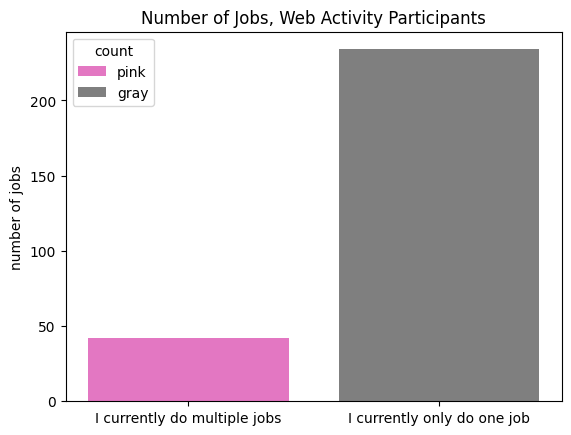

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = grouped_counts_number_of_jobs_df['number_of_jobs']
counts = grouped_counts_number_of_jobs_df['participantCount']
bar_labels = ['pink', 'gray']
bar_colors = ['tab:pink', 'tab:gray']

ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('number of jobs')
ax.set_title('Number of Jobs, Web Activity Participants')
ax.legend(title='count')

plt.show()

In [ ]:
grouped_counts_laborPlatforms = merged_df.groupby('laborPlatforms')['user_id'].nunique()
grouped_counts_laborPlatforms_df = grouped_counts_laborPlatforms.reset_index()
grouped_counts_laborPlatforms_df = grouped_counts_laborPlatforms_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_laborPlatforms_df['completionPercentageBy_laborPlatforms'] = (grouped_counts_laborPlatforms_df['participantCount'] / page24_completionCount)*100
grouped_counts_laborPlatforms_df

laborPlatforms  participantCount  \
0                                           Amara.org                 1   
1                              Amara.org,oDesk,Elance                 1   
2                              Amazon Mechanical Turk                10   
3       Amazon Mechanical Turk,Amara.org,MicroWorkers                 1   
4   Amazon Mechanical Turk,Elance,Prolific,ClickWo...                 1   
..                                                ...               ...   
81                                    Prolific,UpWork                 4   
82            Prolific,UpWork,Lyft,PostMates,DoorDash                 1   
83                          Prolific,UpWork,ThumbTack                 1   
84                             Prolific,UpWork,Toloka                 1   
85                                             UpWork                 1   

    completionPercentageBy_laborPlatforms  
0                                0.357143  
1                                0.357143  
2                                3.571429  
3                                0.357143  
4                                0.357143  
..                                    ...  
81                               1.428571  
82                               0.357143  
83                               0.357143  
84                               0.357143  
85                               0.357143  

[86 rows x 3 columns]

In [ ]:
df0 = grouped_counts_laborPlatforms_df
df0.to_csv('file1.csv')
df0

laborPlatforms  participantCount  \
0                                           Amara.org                 1   
1                              Amara.org,oDesk,Elance                 1   
2                              Amazon Mechanical Turk                10   
3       Amazon Mechanical Turk,Amara.org,MicroWorkers                 1   
4   Amazon Mechanical Turk,Elance,Prolific,ClickWo...                 1   
..                                                ...               ...   
81                                    Prolific,UpWork                 4   
82            Prolific,UpWork,Lyft,PostMates,DoorDash                 1   
83                          Prolific,UpWork,ThumbTack                 1   
84                             Prolific,UpWork,Toloka                 1   
85                                             UpWork                 1   

    completionPercentageBy_laborPlatforms  
0                                0.357143  
1                                0.357143  
2                                3.571429  
3                                0.357143  
4                                0.357143  
..                                    ...  
81                               1.428571  
82                               0.357143  
83                               0.357143  
84                               0.357143  
85                               0.357143  

[86 rows x 3 columns]

In [ ]:
'''
import matplotlib.pyplot as plt

plats = grouped_counts_laborPlatforms_df['laborPlatforms']
counts = grouped_counts_laborPlatforms_df['participantCount']
#bar_labels = ['pink', 'gray']
#bar_colors = ['tab:pink', 'tab:gray']

fig, ax = plt.subplots()
ax.plot(plats, counts, label="dog")
#ax.plot(activity, cat, label="cat")
ax.legend()

#plt.show()
'''

'\nimport matplotlib.pyplot as plt\n\nplats = grouped_counts_laborPlatforms_df[\'laborPlatforms\']\ncounts = grouped_counts_laborPlatforms_df[\'participantCount\']\n#bar_labels = [\'pink\', \'gray\']\n#bar_colors = [\'tab:pink\', \'tab:gray\']\n\nfig, ax = plt.subplots()\nax.plot(plats, counts, label="dog")\n#ax.plot(activity, cat, label="cat")\nax.legend()\n\n#plt.show()\n'

In [ ]:
laborPlatsDict=grouped_counts_laborPlatforms_df.to_dict()

In [ ]:
#dict(keys=grouped_counts_laborPlatforms_df['laborPlatforms'], values=grouped_counts_laborPlatforms_df['participantCount'])

In [ ]:
laborPlatsDict.keys()

dict_keys(['laborPlatforms', 'participantCount', 'completionPercentageBy_laborPlatforms'])

<BarContainer object of 86 artists>

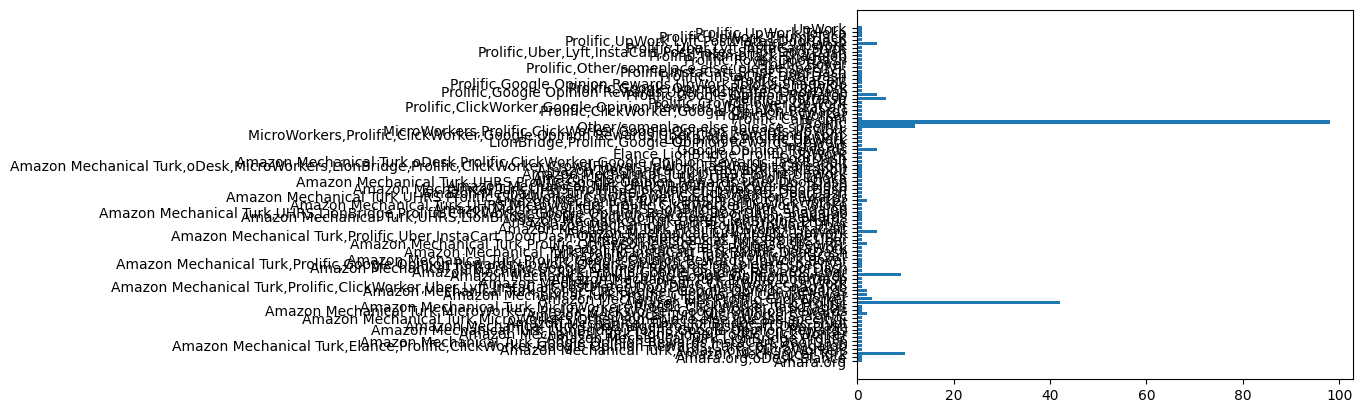

In [ ]:
#plt.plot(grouped_counts_laborPlatforms_df['laborPlatforms'], grouped_counts_laborPlatforms_df['participantCount'])
plt.barh(grouped_counts_laborPlatforms_df['laborPlatforms'], grouped_counts_laborPlatforms_df['participantCount'])



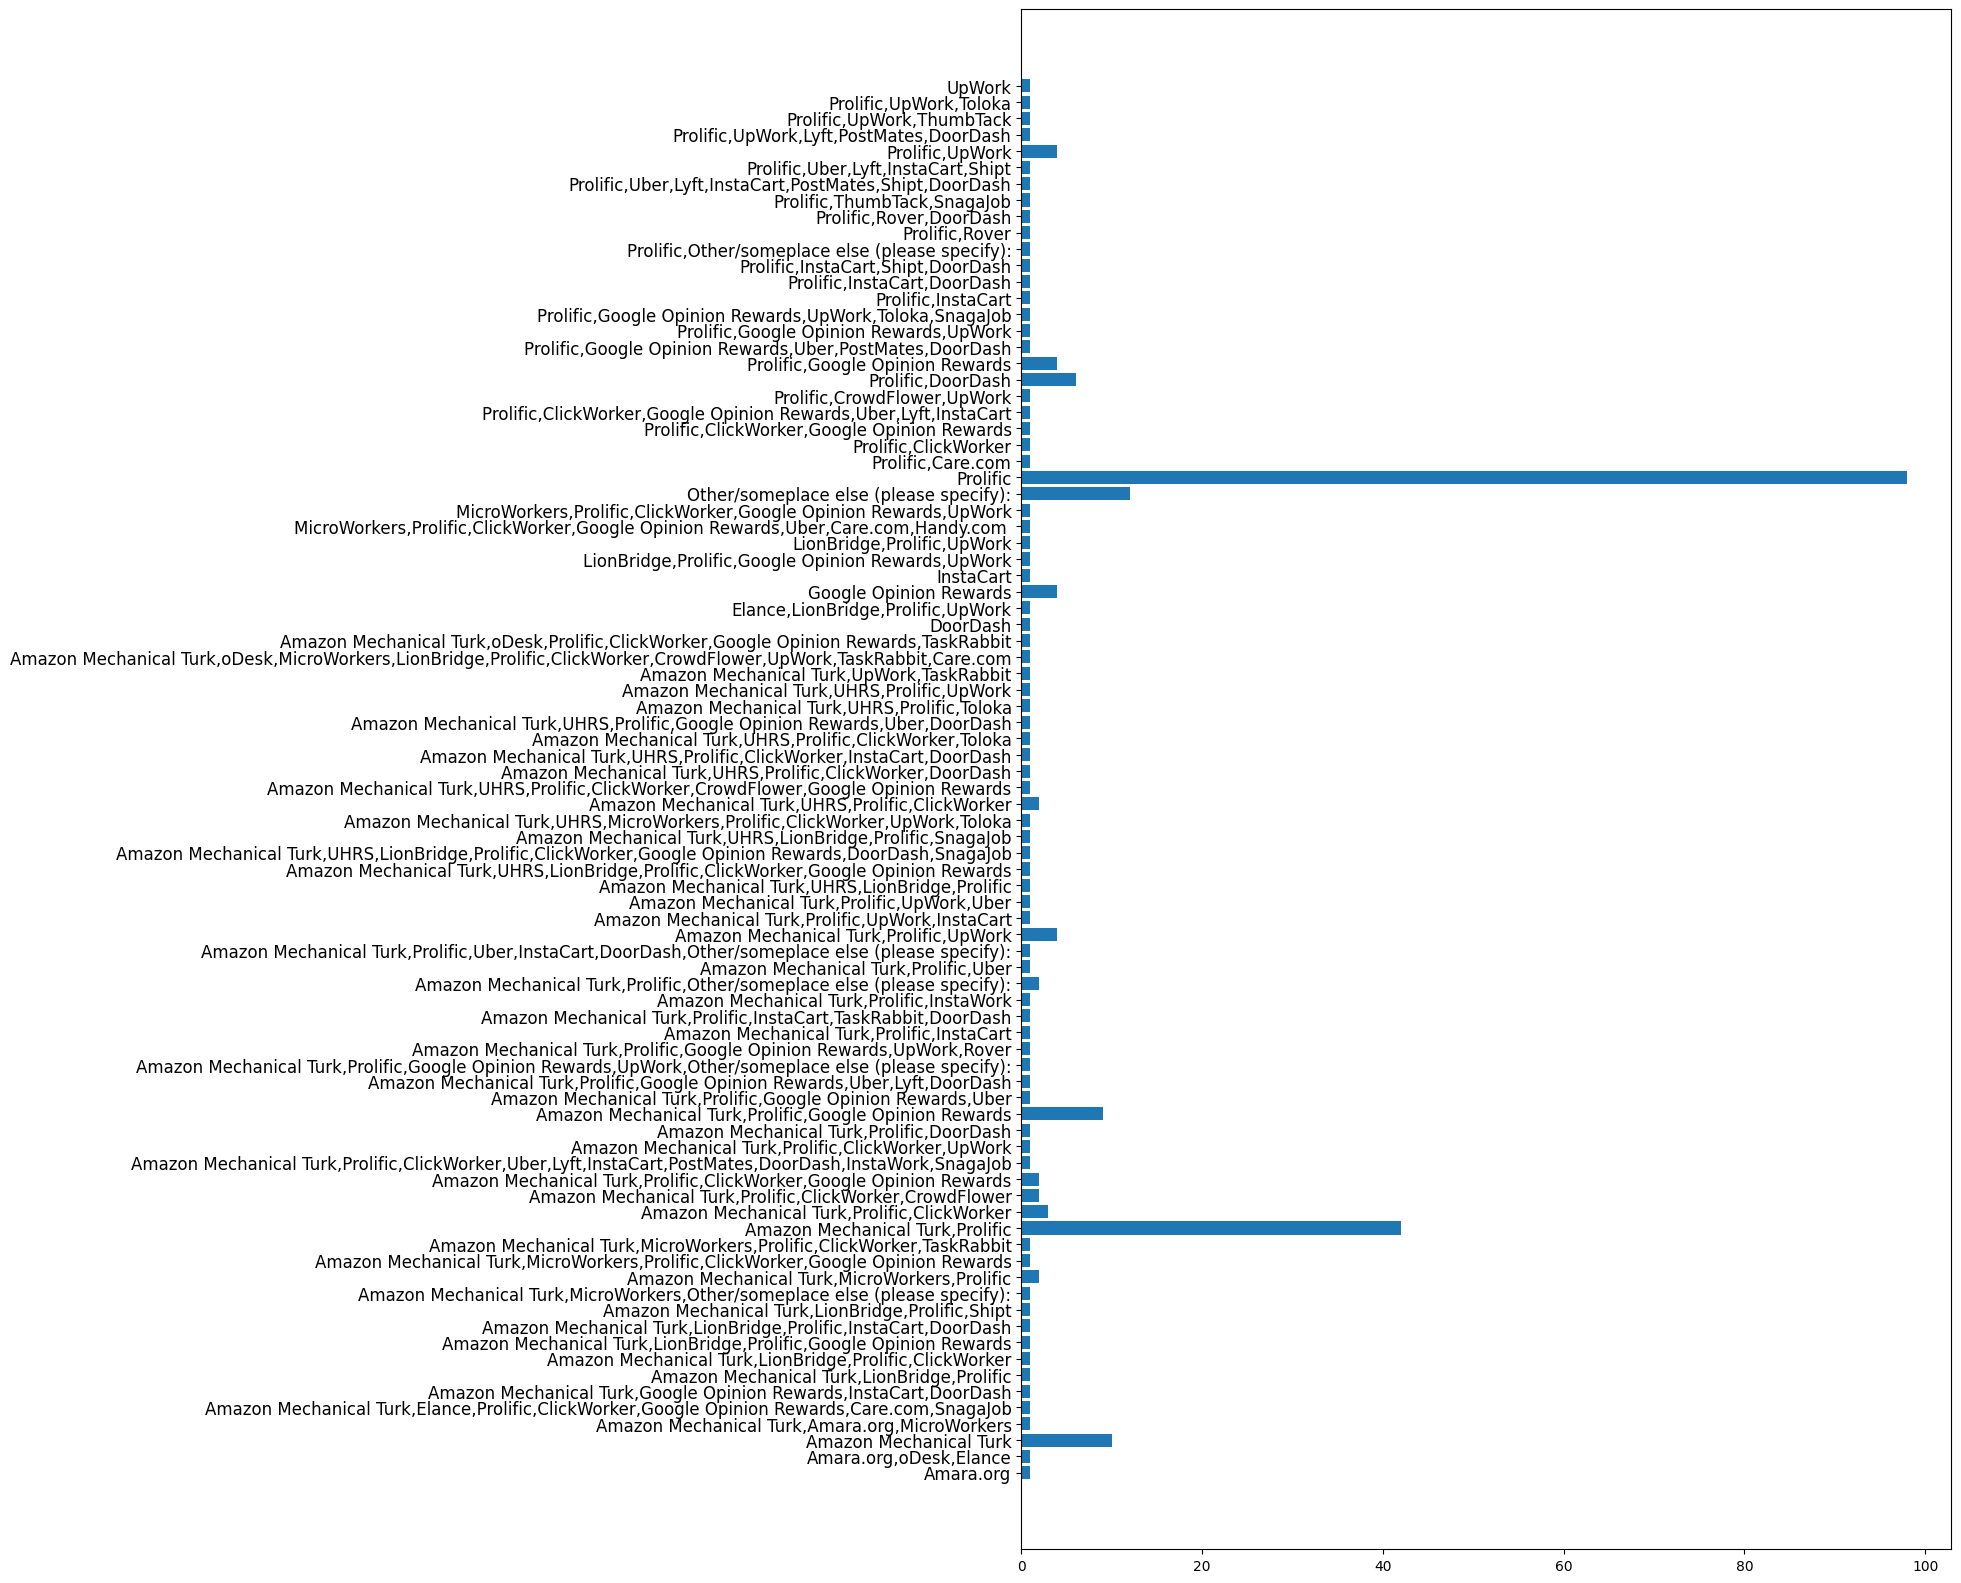

In [ ]:
plt.figure(figsize=(12,20))  # adjust the size (width, height) to your preference
plt.barh(grouped_counts_laborPlatforms_df['laborPlatforms'], grouped_counts_laborPlatforms_df['participantCount'])
plt.yticks(fontsize=12)  # adjust the fontsize to increase/decrease space between y-ticks
plt.show()

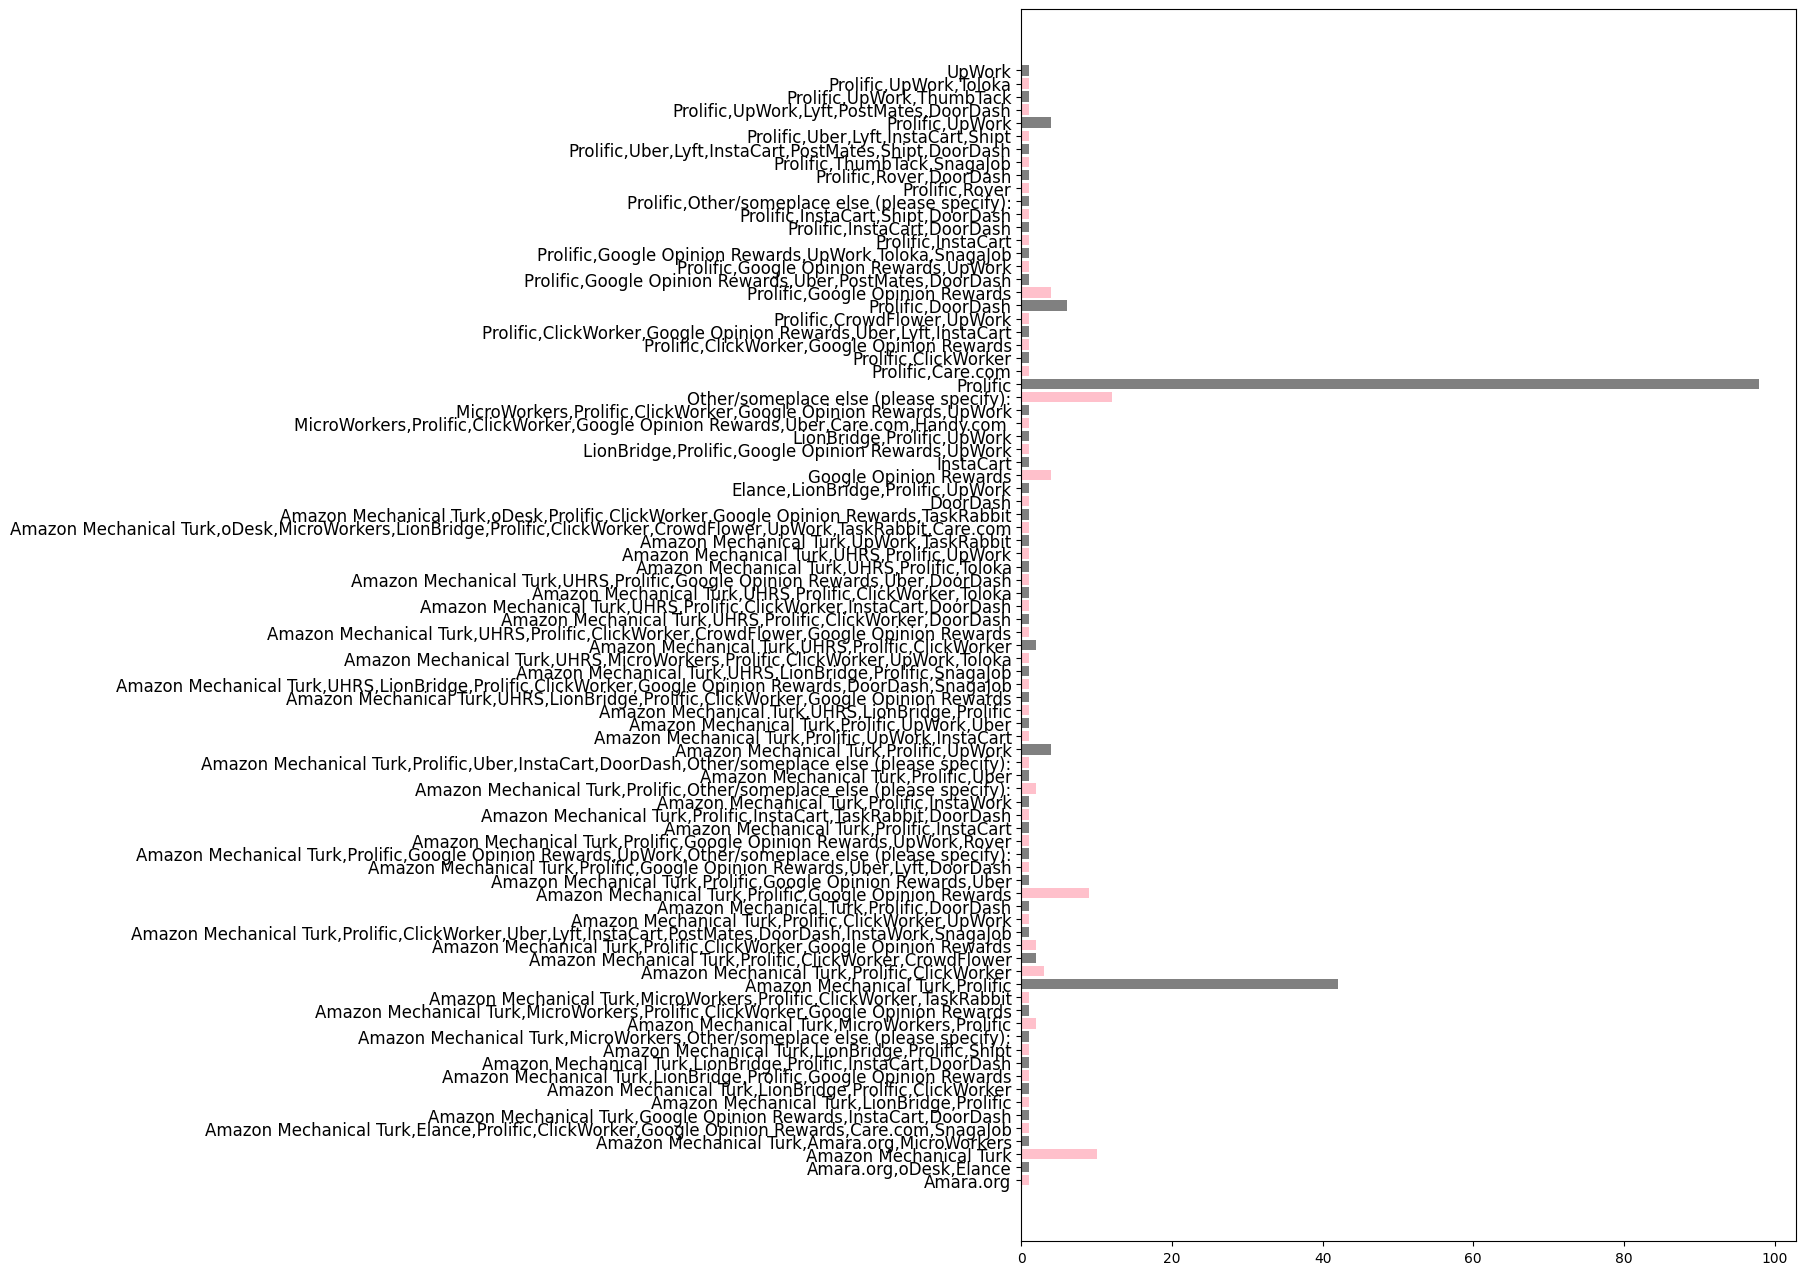

In [ ]:
import numpy as np

plt.figure(figsize=(10,16))

# Create color pattern
colors = ['pink' if i % 2 == 0 else 'gray' for i in range(len(grouped_counts_laborPlatforms_df['laborPlatforms']))]

plt.barh(grouped_counts_laborPlatforms_df['laborPlatforms'], grouped_counts_laborPlatforms_df['participantCount'], color=colors)
plt.yticks(fontsize=12) # increase fontsize to 12. Adjust value for your specific needs.
plt.show()

In [ ]:
surveydata.Q28

1       No
2      Yes
3       No
4       No
5      Yes
      ... 
590     No
591    Yes
592     No
593     No
594     No
Name: Q28, Length: 594, dtype: object

In [ ]:
grouped_counts_hiringExperience = merged_df.groupby('hiringExperience')['user_id'].nunique()
grouped_counts_hiringExperience_df = grouped_counts_hiringExperience.reset_index()
grouped_counts_hiringExperience_df = grouped_counts_hiringExperience_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_hiringExperience_df['completionPercentageBy_hiringExperience'] = (grouped_counts_hiringExperience_df['participantCount'] / page24_completionCount)*100
grouped_counts_hiringExperience_df

hiringExperience  participantCount  completionPercentageBy_hiringExperience
0               No               118                                42.142857
1              Yes               158                                56.428571

In [ ]:
grouped_counts_jobAdvertisingExperience = merged_df.groupby('jobAdvertisingExperience')['user_id'].nunique()
grouped_counts_jobAdvertisingExperience_df = grouped_counts_jobAdvertisingExperience.reset_index()
grouped_counts_jobAdvertisingExperience_df = grouped_counts_jobAdvertisingExperience_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_jobAdvertisingExperience_df['completionPercentageBy_jobAdvertisingExperience'] = (grouped_counts_jobAdvertisingExperience_df['participantCount'] / page24_completionCount)*100
grouped_counts_jobAdvertisingExperience_df

jobAdvertisingExperience  participantCount  \
0                       No               165   
1                      Yes               111   

   completionPercentageBy_jobAdvertisingExperience  
0                                        58.928571  
1                                        39.642857

In [ ]:
grouped_counts_managementExperience = merged_df.groupby('managementExperience')['user_id'].nunique()
grouped_counts_managementExperience_df = grouped_counts_managementExperience.reset_index()
grouped_counts_managementExperience_df = grouped_counts_managementExperience_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_managementExperience_df['completionPercentageBy_managementExperience'] = (grouped_counts_managementExperience_df['participantCount'] / page24_completionCount)*100
grouped_counts_managementExperience_df

managementExperience  participantCount  \
0                     No                95   
1  Please self describe:                 1   
2                    Yes               180   

   completionPercentageBy_managementExperience  
0                                    33.928571  
1                                     0.357143  
2                                    64.285714

In [ ]:
grouped_counts_languages = merged_df.groupby('languages')['user_id'].nunique()
grouped_counts_languages_df = grouped_counts_languages.reset_index()
grouped_counts_languages_df = grouped_counts_languages_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_languages_df['completionPercentageBy_languages'] = (grouped_counts_languages_df['participantCount'] / page24_completionCount)*100
grouped_counts_languages_df

languages  participantCount  \
0                                            English               247   
1                                     English,Arabic                 1   
2       English,Chinese (Simplified and Traditional)                 2   
3  English,Chinese (Simplified and Traditional),F...                 1   
4                                      English,Dutch                 1   
5                                   English,Japanese                 1   
6                                     English,Other:                 1   
7                                    English,Spanish                20   
8  English,Spanish,Italian,Portuguese,Chinese (Si...                 1   
9                                            Spanish                 1   

   completionPercentageBy_languages  
0                         88.214286  
1                          0.357143  
2                          0.714286  
3                          0.357143  
4                          0.357143  
5                          0.357143  
6                          0.357143  
7                          7.142857  
8                          0.357143  
9                          0.357143

In [ ]:
grouped_counts_ai_familiarity = merged_df.groupby('ai_familiarity')['user_id'].nunique()
grouped_counts_ai_familiarity_df = grouped_counts_ai_familiarity.reset_index()
grouped_counts_ai_familiarity_df = grouped_counts_ai_familiarity_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_ai_familiarity_df['completionPercentageBy_ai_familiarity'] = (grouped_counts_ai_familiarity_df['participantCount'] / page24_completionCount)*100
grouped_counts_ai_familiarity_df

ai_familiarity  participantCount  \
0  Neither familiar or unfamiliar                13   
1               Somewhat familiar               152   
2             Somewhat unfamiliar                11   
3                   Very familiar                98   
4                 Very unfamiliar                 2   

   completionPercentageBy_ai_familiarity  
0                               4.642857  
1                              54.285714  
2                               3.928571  
3                              35.000000  
4                               0.714286

In [ ]:
grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings = merged_df.groupby('increased_use_of_ai_computer_programs_daily_life_feelings')['user_id'].nunique()
grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings_df = grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings.reset_index()
grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings_df = grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings_df.rename(columns={'user_id': 'participantCount'})
grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings_df['completionPercentageBy_increased_use_of_ai_computer_programs_daily_life_feelings'] = (grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings_df['participantCount'] / page24_completionCount)*100
grouped_counts_increased_use_of_ai_computer_programs_daily_life_feelings_df

increased_use_of_ai_computer_programs_daily_life_feelings  participantCount  \
0                     Equally concerned and excited                       117   
1                       More concerned than excited                        72   
2                       More excited than concerned                        75   
3                                           Not sure                       12   

   completionPercentageBy_increased_use_of_ai_computer_programs_daily_life_feelings  
0                                          41.785714                                 
1                                          25.714286                                 
2                                          26.785714                                 
3                                           4.285714

In [ ]:
merged_df.columns

Index(['user_id', 'prolificID', 'age', 'race', 'gender', 'sexualOrientation',
       'disabled', 'eduLevel', 'location', 'languages', 'number_of_jobs',
       'laborPlatforms', 'hiringExperience', 'jobAdvertisingExperience',
       'managementExperience', 'skills01', 'skills02', 'skills03', 'skills04',
       'skills05', 'skills06', 'skills07', 'skills08', 'skills09', 'skills10',
       'ai_familiarity',
       'increased_use_of_ai_computer_programs_daily_life_feelings',
       'main_reason__more_excited_than_concerned_ai_computer_programs_daily_life',
       'main_reason__more_concerned_than_excited_ai_computer_programs_daily_life',
       'believe_possible_design_fair_ai'],
      dtype='object')

In [ ]:
grouped_counts_main_reason_more_excited_than_concerned = merged_df.groupby('main_reason__more_excited_than_concerned_ai_computer_programs_daily_life')['user_id'].nunique()
grouped_counts_main_reason_more_excited_than_concerned = pd.DataFrame(grouped_counts_main_reason_more_excited_than_concerned)
grouped_counts_main_reason_more_excited_than_concerned_df = grouped_counts_main_reason_more_excited_than_concerned.rename(columns={'user_id': 'participantCount'})
grouped_counts_main_reason_more_excited_than_concerned_df['completionPercentageBy_main_reason__more_excited_than_concerned_ai_computer_programs_daily_life'] = (grouped_counts_main_reason_more_excited_than_concerned_df['participantCount'] / page24_completionCount)*100
grouped_counts_main_reason_more_excited_than_concerned_df.index

Index(['AI is interesting, exciting', 'Handles mundane, tedious tasks',
       'Helps with work/labor', 'Inevitable progress, is the future',
       'Inevitable progress, is the future,AI is interesting, exciting,Other people’s fears are based on sci-fi, not reality Other',
       'Inevitable progress, is the future,Helps humans with difficult/dangerous tasks',
       'Makes life, society better',
       'Makes life, society better,Handles mundane, tedious tasks,AI is interesting, exciting',
       'Makes life, society better,Helps with work/labor,AI is interesting, exciting,Helps humans with difficult/dangerous tasks,More accurate than humans',
       'Makes life, society better,Inevitable progress, is the future',
       'Makes life, society better,Inevitable progress, is the future,Handles mundane, tedious tasks,AI is interesting, exciting,Helps humans with difficult/dangerous tasks',
       'Makes life, society better,Saves time, more efficient',
       'Makes life, society better,

In [ ]:
import numpy as np

plt.figure(figsize=(40,40))

# Create color pattern
colors = ['pink' if i % 2 == 0 else 'gray' for i in range(len(grouped_counts_main_reason_more_excited_than_concerned_df.index))]

plt.barh( grouped_counts_main_reason_more_excited_than_concerned_df.index, grouped_counts_main_reason_more_excited_than_concerned_df['participantCount'], color=colors)
plt.yticks(fontsize=60) # increase fontsize to 12. Adjust value for your specific needs.
plt.show()

In [ ]:
grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life  = merged_df.groupby('main_reason__more_concerned_than_excited_ai_computer_programs_daily_life')['user_id'].nunique()
grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life  = pd.DataFrame(grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life)
grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life_df = grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life.rename(columns={'user_id': 'participantCount'})
grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life_df['completionPercentageBy_main_reason__more_concerned_than_excited_ai_computer_programs_daily_life'] = (grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life_df['participantCount'] / page24_completionCount)*100
grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life_df

participantCount  \
main_reason__more_concerned_than_excited_ai_com...                     
AI fails, makes mistakes                                           2   
AI fails, makes mistakes,Human bias coded into AI                  1   
AI will get too powerful, outsmarting people Pe...                 6   
AI will get too powerful, outsmarting people Pe...                 1   
AI will get too powerful, outsmarting people Pe...                 1   
Concerns about govt./tech companies using AI Do...                 1   
Concerns about govt./tech companies using AI Do...                 1   
Lack of human connection, qualities                                1   
Lack of human connection, qualities,People beco...                 1   
Loss of human jobs                                                 7   
Loss of human jobs,AI fails, makes mistakes,Unf...                 1   
Loss of human jobs,AI will get too powerful, ou...                 1   
Loss of human jobs,AI will get too powerful, ou...                 1   
Loss of human jobs,AI will get too powerful, ou...                 1   
Loss of human jobs,Human bias coded into AI,Lac...                 1   
Loss of human jobs,Lack of human connection, qu...                 1   
Loss of human jobs,Lack of human connection, qu...                 1   
Loss of human jobs,Lack of human connection, qu...                 1   
Loss of human jobs,Lack of human connection, qu...                 1   
Loss of human jobs,Lack of human connection, qu...                 1   
Loss of human jobs,Lack of human connection, qu...                 1   
Loss of human jobs,People becoming too reliant ...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 3   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 2   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
Loss of human jobs,Surveillance, hacking, digit...                 1   
People becoming too reliant on AI/tech                             2   
People becoming too reliant on AI/tech,Concerns...                 1   
Prefer self explain                                                1   
Surveillance, hacking, digital privacy                             4   
Surveillance, hacking, digital privacy,AI will ...                 1   
Surveillance, hacking, digital privacy,AI will ...                 1   
Surveillance, hacking, digital privacy,AI will ...                 1   
Surveillance, hacking, digital privacy,AI will ...                 1   
Surveillance, hacking, digital privacy,Concerns...                 1   
Surveillance, hacking, digital privacy,Lack of ...                 1   
Surveillance, hacking, digital privacy,Lack of ...                 1   
Surveillance, hacking, digital privacy,People b...                 1   
Surveillance, hacking, digital privacy,People b...                 1   
Surveillance, hacking, digital privacy,People b...                 1   
Unforeseen consequences/effects                                    1   

                                                    completionPercentageBy_main_reason__mor

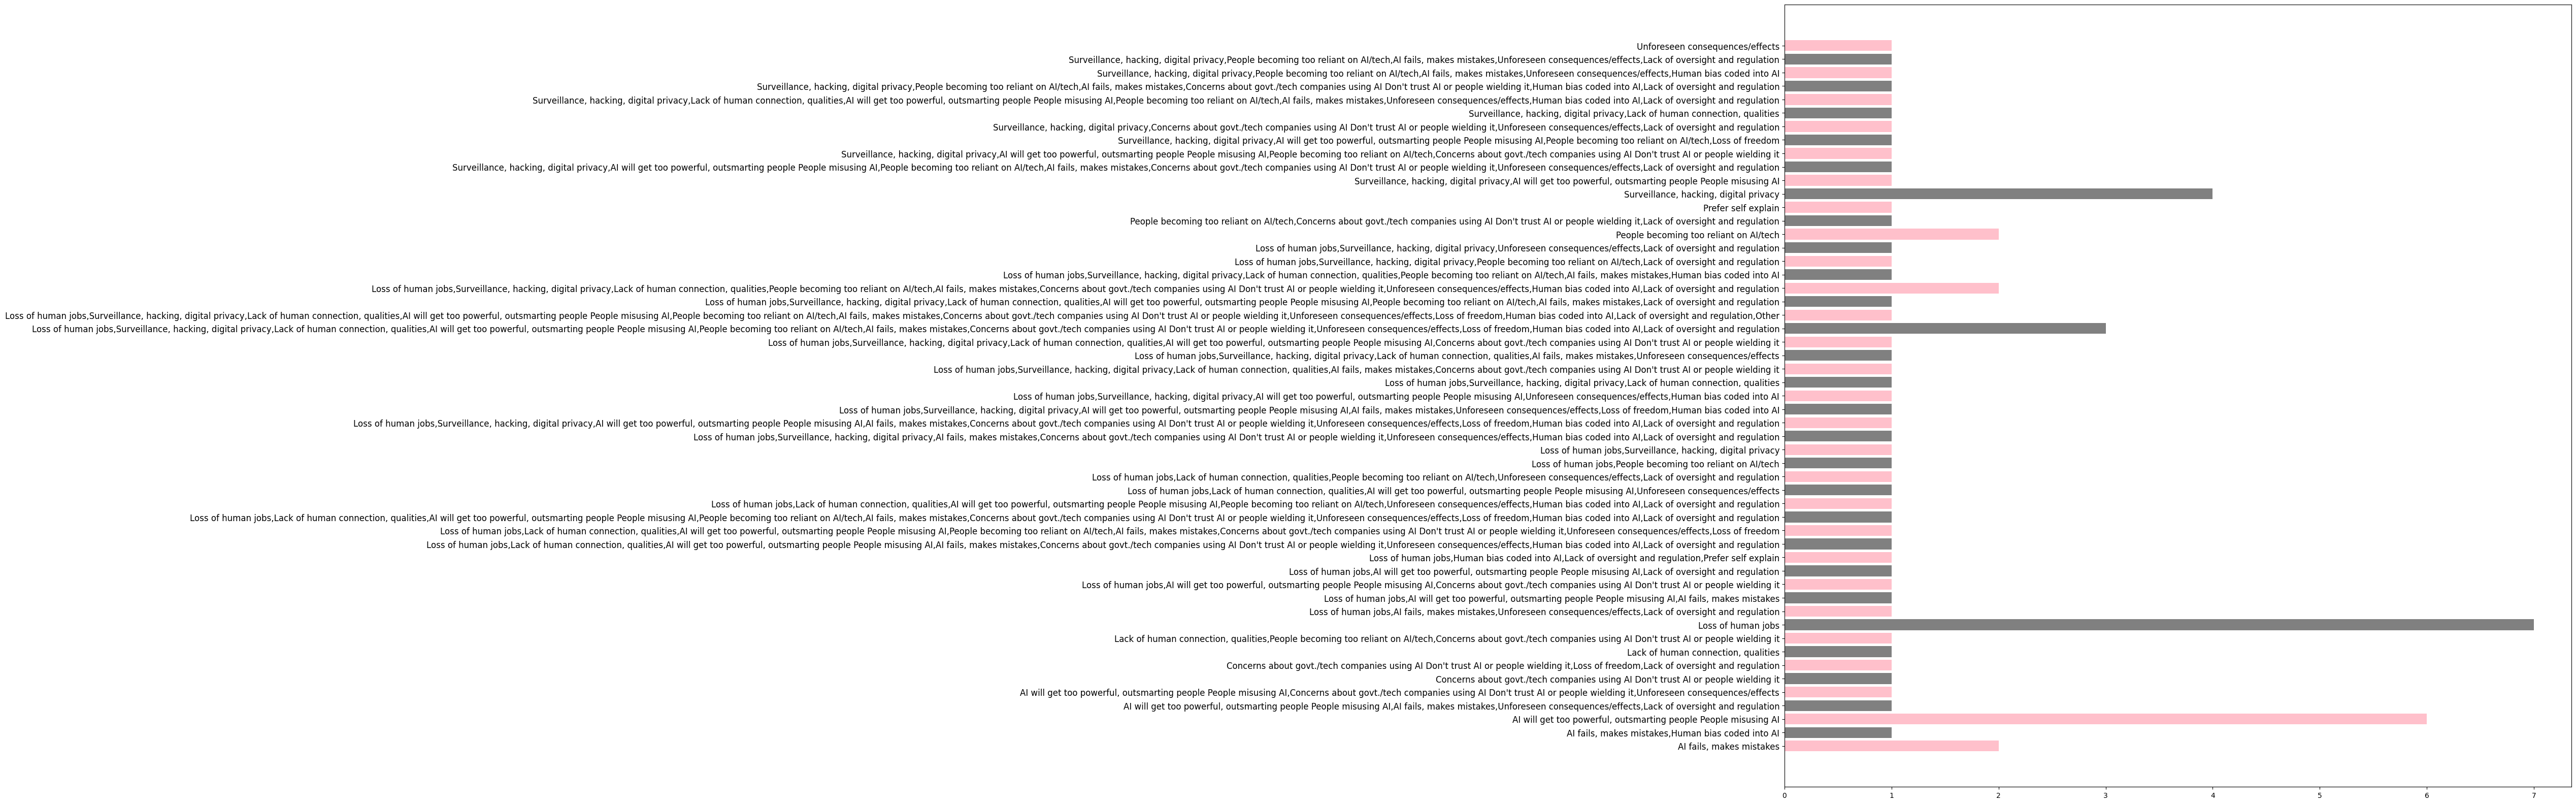

In [ ]:
import numpy as np

plt.figure(figsize=(20,20))

# Create color pattern
colors = ['pink' if i % 2 == 0 else 'gray' for i in range(len(grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life_df.index))]

plt.barh( grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life_df.index, grouped_counts_main_reason_more_concerned_than_excited_ai_computer_programs_daily_life_df['participantCount'], color=colors)
plt.yticks(fontsize=12) # increase fontsize to 12. Adjust value for your specific needs.
plt.show()